In [4]:
import numpy as np
import json
import scipy
from scipy.spatial import distance_matrix
from sklearn.linear_model import LogisticRegression
import random
import torchvision

In [ ]:
#%pip install gudhi

In [ ]:
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import gudhi

In [ ]:
def kwargValidation(cls: str, func : str, **kwargs):
        with open('/kwargsVerification.JSON', 'r') as file:
            verification = json.load(file)
            funcVer = verification[cls][func]
            for key in funcVer["Variables"]:
                if key in kwargs.keys():
                    if str(type(kwargs[key])) != funcVer["Types"][key]:
                        raise Exception("The given %s variable is not of the correct type" %key)
                    else:
                        valList = [eval(condition) for condition in funcVer["Validation"][key]]
                        valList = [condition(kwargs[key]) for condition in valList]
                        if not all(valList):
                            raise Exception("The given %s variable does not satisfy the condition for this variable" %key)
                else:
                    try:
                        kwargs[key] = eval(funcVer["Default"][key])(kwargs)
                    except Exception as e:
                        print(e)
                        kwargs[key] = funcVer["Default"][key]


        return kwargs

# The Model

In [7]:
#%pip install persim

In [ ]:
from persim import PersistenceImager as pimg
class TopologicalFeatures_Detection:
    def __init__(self, **kwargs):
        kwargs = kwargValidation(self.__class__.__name__,"init", **kwargs)
        for key, value in kwargs.items():
            setattr(self, key, value)
        return

    def __heightMatrix(self, angle: float, size: int) -> np.ndarray:
        heightMatrix = np.zeros((size, size), np.float32)
        step = self.scale/size
        for i in range(size):
            for j in range(size):
                heightMatrix[i, j] = float(np.cos(angle)*((size-i)*step+ -1) + np.sin(angle)*((j)*step -1))
        return heightMatrix

    def detect(self, image: np.ndarray, size: int, alpha: float = 0.5) -> tuple:
        pers_imager = pimg(pixel_size=.1,birth_range=(-np.sqrt(2)-.01,np.sqrt(2)+.01))
        H0_Block = []
        H1_Block = []
        for direction in self.directions:
            heightMatrix = self.__heightMatrix(direction, size)
            Image = np.round((image > alpha)).reshape((size,size))
            heightImgMatrix = Image * heightMatrix
            heightImgMatrix[heightImgMatrix == 0] = float('inf')
            Complex = gudhi.CubicalComplex(top_dimensional_cells=heightImgMatrix)
            Complex.persistence()
            D0 = Complex.persistence_intervals_in_dimension(0)
            D1 = Complex.persistence_intervals_in_dimension(1)
            D0[D0 == float('inf')] = self.scale*np.sqrt(2)+.01
            D1[D1 == float('inf')] = self.scale*np.sqrt(2)+.01
            pers_img_0 = pers_imager.transform(D0)
            pers_img_1 = pers_imager.transform(D1)
            H0_Block.append(pers_img_0.reshape(pers_img_0.shape[0]*pers_img_0.shape[1],))
            H1_Block.append(pers_img_1.reshape(pers_img_0.shape[0]*pers_img_0.shape[1],))
        return (H0_Block, H1_Block)

    def matching(self, SensedtopInformation, RefTopInformation) -> list:
        cycles = [[(i+j) % self.numOfDirections for i in range(self.numOfDirections)] for j in range(self.numOfDirections)]
        probs = []
        for ref in RefTopInformation:
            D0 = distance_matrix(ref[0],SensedtopInformation[0])
            D1 = distance_matrix(ref[1],SensedtopInformation[1])
            BestCycle = None
            currentMin = float('inf')
            for cycle in cycles:
                score = sum(D0[[i for i in range(self.numOfDirections)],cycle]*D0[[i for i in range(self.numOfDirections)],cycle])+sum(D1[[i for i in range(self.numOfDirections)],cycle]*D1[[i for i in range(self.numOfDirections)],cycle])/(2*self.numOfDirections)
                if score < currentMin:
                    BestCycle = cycle
                    currentMin = score
            probs.append([currentMin,BestCycle])
        return probs

    def train(self, training_dataset, training_label, RefTopInformation, size) -> None:
        TopInfo = list(map(lambda x: self.detect(x,size),training_dataset))
        matchingProbs = list(map(lambda x: self.matching(x,RefTopInformation), TopInfo))
        model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
        model.fit(matchingProbs, training_label)
        self.model = model
        return

    def evaluate(self, test_dataset, test_label, RefTopInformation, size) -> None:
        TopInfo = list(map(lambda x: self.detect(x,size),test_dataset))
        matchingProbs = list(map(lambda x: self.matching(x,RefTopInformation), TopInfo))
        print(self.model.score(matchingProbs, test_label))
        return


# Step One: Feature Detection
In this step we want to detect topological feature by "scanning" the image in different direction. We do this by considering a height function h<sub>v<sub>i</sub></sub>(x) = v<sub>i</sub> $\cdot$ x for i = 1,...,N. Each i will produce a persistence diagram and hence a persistence image (i.e a vector) summerizing the topological features in that direction.

In [ ]:
# Download and transform the MNIST dataset
transform = transforms.Compose([
    # Convert images to PyTorch tensors which also scales data from [0,255] to [0,1]
    transforms.ToTensor()
])

# Download training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.78MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 155kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.77MB/s]


In [8]:
%pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 14.8 MB/s  0:00:04m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 13.8 MB/s  0:00:01m0:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
    Uninstalling numpy-2.3.4:
      Successfully uninstalled numpy-2.3.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ripser 0.6.12 requires Cython, which is not installed.
numpy-typing-compat 20250818.2.3 requires numpy<2.4,>=2.3, but you have numpy 2.2.6 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import cv2
import scipy.ndimage as ndi
T = TopologicalFeatures_Detection(numOfDirections = 8)
Image, Label = train_dataset[0]
Image = cv2.resize(src=np.array(Image).reshape(28,28),dsize=(50, 50),interpolation=cv2.INTER_CUBIC)
cy, cx = ndi.center_of_mass(Image)
t = np.float32([[1, 0, 25-cx], [0, 1, 25-cy]])

Image = cv2.warpAffine(Image, t, (50, 50))
cy, cx = ndi.center_of_mass(Image)

print(cy, cx)
H0_demo, H1_demo = T.detect(Image,50)
plt.imshow((Image).reshape(50,50))

# Step Two: Feature Matching

In [ ]:
train_dataset_images = []
train_dataset_label = []

for image, label in train_dataset:
    train_dataset_images.append(np.array(image).reshape(28,28))
    train_dataset_label.append(label)

In [ ]:
RefPics = []

new_train_dataset = []
new_train_dataset_label = []

for i in range(9):
    ind = np.where(np.array(train_dataset_label) == i)[0]
    j = random.choice(list(ind))
    image = train_dataset_images[j]
    H0, H1 = T.detect(image,28)
    RefPics.append([H0,H1])

    #rotIndex = []
    #for j in range(20):
        #angle = random.uniform(0,360)
        #while angle in tempIndex:
            #angle = random.uniform(0,360)
        #rotIndex.append(refIndex)
        #new_train_dataset.append(scipy.ndimage.rotate(image, angle, reshape=False))
        #new_train_dataset_label.append(train_dataset_label[ind])


25.29343865064919 23.753213825262907
[[np.float64(0.0005548993058222125), [0, 1, 2, 3, 4, 5, 6, 7]]]


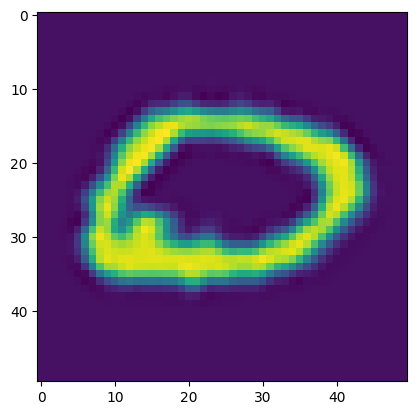

In [ ]:
import cv2
rotation_matrix = cv2.getRotationMatrix2D((25,25), 135, 1)
Image2 , Label2= train_dataset[1]
Image2 = cv2.resize(src=np.array(Image2).reshape(28,28),dsize=(50, 50),interpolation=cv2.INTER_CUBIC)
cy, cx = ndi.center_of_mass(Image2)
t = np.float32([[1, 0, 25-cx], [0, 1, 25-cy]])
rotated_image = cv2.warpAffine(src=np.array(Image2).reshape(50,50), M=rotation_matrix, dsize=(50, 50))

rotated_image = cv2.warpAffine(rotated_image, t, (50, 50))
cy, cx = ndi.center_of_mass(rotated_image)
print(cy, cx)
plt.imshow(rotated_image)

H0_demo_rot, H1_demo_rot = T.detect(rotated_image,50)

Probs = T.matching([H0_demo, H1_demo], [[H0_demo_rot, H1_demo_rot]])
print(Probs)

In [ ]:
print("Training Model...")
T.train(train_dataset_images[0:500],train_dataset_label[0:500],RefPics,28)
print("Evaluating Model...")
T.evaluate(train_dataset_images[0:100],train_dataset_label[0:100],RefPics,28)

Training Model...


IndexError: index 4 is out of bounds for axis 0 with size 4